# Clasification and Semantic Segmentation of Blancked Resumes
Goal : The ultimate objective is : 
    - to locate all company logos in a resume, find their associated company name, find their industry sector, etc, 
    - to locate and classify all icons that refers to a skill/hobby
This test is a very wide problem. With the provided resources, you need to properly define what you will be focusing on. 

# Quick Introduction
Given the fact that I don't have access to a GPU (working on Mac), I only defined the models, created some new datasets, and presented the main ideas I had regarding the subject and the ressources provided. On the report, I present the approach I had to the problem and to the datasets provided by Riminder. First, I created a deep model for binary classification, to detect wether a resume has a visual, logo or icon, then I defined a new dataset to augment the dataset, and to balance it. 
After that first model, I defined a second deep model, more specific to semantic segmentation, to detect exactly the location of these visuals - when found -, in each blank resume. 

# 1- Exploration of given data : 
 The function __prepare_data()__ to prepare, extract information from the given datasets and returns two numpy arrays, one for the resumes and the other one for their labels . It takes as input the shape according to which the images will be extracted. 
 I chose to use a (224, 224) since the majority of predefined deep learning architectures on Keras (VGG16, ResNet50..) use the same shape of images. 

In [5]:
from toolbox import prepare_data
input_size = 224
x, y = prepare_data(input_size=input_size)

print('Number of resumes with company : ' , sum(y=='has_company'))
print('Number of resumes with icon : ' , sum(y=='has_icon'))
print('Number of resumes with both : ' , sum(y=='has_both'))
print('Number of resumes with nothing : ' , sum(y=='nothing'))

Number of resumes with company :  234
Number of resumes with icon :  55
Number of resumes with both :  4
Number of resumes with nothing :  1362


Not enough images for each class..  
We will transform the task to a binary classification : detecting wether a resume contains a visual (company logo, hobbies icon, both), or has none of these.  
    - 1  : has no company, no icon logo, nothing  
    - 0 : has either a company logo, an icon, or both   
still a very unbalanced problem... 

In [9]:
import matplotlib.pyplot as plt 
import numpy as np
y_binary = np.array([int(label =='nothing') for label in y])

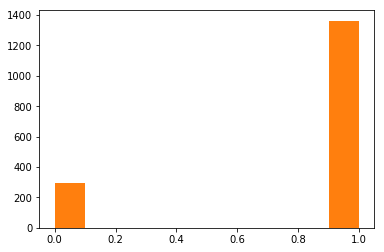

In [15]:
plt.hist(y_binary)
plt.show()

__Reading and Preprocessing the images__ :  
- Used ImageDataGenerator from keras preprocessing images package. 
- The advantage is generating generators, and batchs from a given directory or numpy array of images. 
- It allows many preprocessing tasks aswell, such as scaling, reshaping, and normalising : However, due to these tasks can be very greedy in terms computation force, so I only used a simple rescaling.
- Also used a validation split of 0.1, to do some cross validation over the data. 
- The choice of the batch size depends on the computation power one has. 16 will allow me to run at least one epoch. 

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

batch_size = 16

datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split = 0.1,
        )

final_x = x
final_y = y_binary

train_generator = datagen.flow(final_x,
                      to_categorical(final_y),
                      batch_size = batch_size, 
                      shuffle = True, 
                      subset='training')

validation_generator = datagen.flow(final_x,
                      to_categorical(final_y),
                      batch_size = batch_size, 
                      shuffle = True, 
                      subset='validation')

__Defining the Deep Classifier : __ 
- A VGG16 or ResNet50 Classifier : used the model predefined in Keras applications 
- I will use the ResNet50 for the rest, because the number of parameters is less important, while they both tend to have more or less the same scores on image classification tasks. 

__About Transfer Learning : __ I used transfer learning from pretrained models on the ImageNet challenge, by using the same weights to initialize my convolutional layers. Even though the task of natural image classification is completely different from the current task. It has been proven that the first convolution layers, can be very similar and thus, the transfer learning improves the convergence time and performance of the model. 

In [23]:
from toolbox import build_vgg_model, build_resnet_model

clf_model = build_resnet_model(input_size=input_size,nb_classes=2)

clf_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Given the fact that data is unbalanced, I compute class weights then give it to the model. 

In [24]:
from sklearn.utils import class_weight
from keras.optimizers import Adam
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(final_y), 
                final_y)

adam = Adam(lr = 0.0001)

clf_model.compile(optimizer = adam,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
clf_model.fit_generator(train_generator,
                        class_weight=class_weights,
                        shuffle = True,
                        epochs = 10, 
                        validation_data=validation_generator)

# Data Augmentation : Generating new data set from existing blank resumes  
- Resume are different from other natural images, where a rotation, scale change or other geometric transformations can be sufficient to augment data. The resume is an image where structure is important :  the header is usually for photos and candidate information, while the body contains the majority of text and the sides can contain visuals and logos.  
- Thus, here is the approach I followed : I downloaded many icons from the provided websites, then created a function that takes as an argument all the empy resumes from the labeled data. I defined a variable __icons per resume__ which defines the number of icons I will add to each empy resume. Hence, all the empty resumes have icons now, and the advantage is that it allows me to have a mask for each one of these new images : a mask that i will use later for the semantic segmentation task. 

In [7]:
import numpy as np 
import glob
from PIL import Image
from toolbox import prepare_data
import matplotlib.pyplot as plt 
import random

def prepare_data_seg(resumes, 
                     labels, 
                     resume_size = 224, 
                     icons_size = 24, 
                     icon_per_resume = 3 
                     ):
    
    icons_sn_path  = '/Users/sayemothmane/Documents/MVA/Riminder/icons/145797-social-network-logo-collection/png'
    icons_es_path = '/Users/sayemothmane/Documents/MVA/Riminder/icons/png'
    icons = []
    
    for filename in glob.glob(icons_sn_path+'/*.png'): #assuming gif
            im=Image.open(filename).resize((icons_size, icons_size))
            im = np.array(im.convert("RGB"))
            im[im==0]=255
            icons.append(im)  
    for filename in glob.glob(icons_es_path+'/*.png'): #assuming gif
            im=Image.open(filename).resize((icons_size, icons_size))
            im = np.array(im.convert("RGB"))
            #im[im==0]=255
            icons.append(im)
        
    icons = np.array(icons)


    #x , y = prepare_data(resume_size)

    empty_resumes = resumes[labels=='nothing', :, :,:]
        
    margin = 10
    new_resumes = []
    masks=[]
    for resume in empty_resumes: 
        icons_list = random.sample(range(len(icons)), icon_per_resume)
        for icon in icons_list : 
            mask  = np.zeros((resume_size, resume_size))
            pos_w = random.randint(margin, resume_size-icons_size-margin)
            pos_l = random.randint(margin, resume_size-icons_size-margin)
            new_resume = np.array(resume, copy = True)
            new_resume[pos_l:icons_size+pos_l, pos_w:icons_size+pos_w, :] = icons[icon, :, :]
            mask[pos_l:icons_size+pos_l, pos_w:icons_size+pos_w] = 1
            new_resumes.append(new_resume)
            masks.append(mask)
        
    masks = np.array(masks)
    new_resumes = np.array(new_resumes)
    
    return new_resumes, masks 

In [10]:
icons_size = 24

x_add, masks = prepare_data_seg(resumes=x, 
                                labels = y, 
                                resume_size = input_size, 
                                icons_size = icons_size, 
                                icon_per_resume = 2)

final_x = np.concatenate((x,x_add), axis=0)
final_y = np.concatenate((y_binary , np.zeros(x_add.shape[0])))

/Users/sayemothmane/anaconda3/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


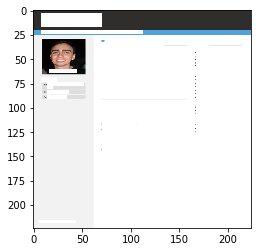

In [35]:
empty_resumes = x[y=='nothing', :, :,:]
plt.imshow(empty_resumes[10])
plt.show()

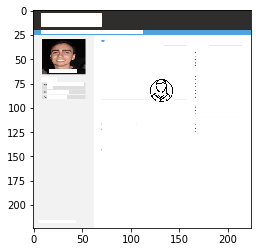

In [37]:
plt.imshow(x_add[20])
plt.show()

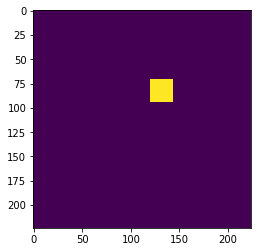

In [38]:
plt.imshow(masks[20])
plt.show()

# Use the augmented dataset for the classification task :

In [ ]:
datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split = 0.1,
        )

final_x = np.concatenate((x,x_add), axis=0)
final_y = np.concatenate((y_binary , np.zeros(x_add.shape[0])))

train_generator = datagen.flow(final_x,
                      to_categorical(final_y),
                      batch_size = batch_size, 
                      shuffle = True, 
                      subset='training')

validation_generator = datagen.flow(final_x,
                      to_categorical(final_y),
                      batch_size = batch_size, 
                      shuffle = True, 
                      subset='validation')

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(final_y), 
                final_y)


#============ Defining first binary classification model ==================

clf_model = build_vgg_model(input_size=input_size,nb_classes=2)

#clf_model = build_resnet_model(input_size=input_size,nb_classes=2)

adam = Adam(lr = 0.0001)

clf_model.compile(optimizer = adam,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

clf_model.fit_generator(train_generator,
                        class_weight=class_weights,
                        shuffle = True,
                        epochs = 10, 
                        validation_data=validation_generator)

# Semantic Segmentation : 
- The goal of this part is to define localize the visual (logo, icons..) within each resume. The architecture of models I chose to use, is the known Fully Convolutional Networks. 
- I implemented the FCN_VGG_32. Being constrained by time I wasn't able to look for some pretrained models, on segmentation datasets such as Pascal VOC 2011, specially for Keras... Would have been interesting to see the effect of transfer learning on such task aswell.
- The dataset I use is the one I created before. The masks of the 'new_resumes' are know since I placed them on empty resumes. I use also some empty resumes, with empy masks..

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model
from BilinearUpSampling import *

def build_fcn_vgg_32(input_shape = (224, 224, 3), nb_classes = 2):
    
    vgg_model = VGG16(
            include_top = False,
            weights='imagenet',
            input_shape = input_shape
            )
        
    vgg_output = Conv2D(4096,
                        (7,7), 
                       activation = 'relu', 
                       padding = 'same')(vgg_model.output)
    vgg_output = Dropout(0.5)(vgg_output)
 
    vgg_output = Conv2D(4096,
                        (7,7),
                       activation = 'relu', 
                       padding = 'same')(vgg_output)
    vgg_output = Dropout(0.5)(vgg_output)

    vgg_output = Conv2D(nb_classes,
                        (1,1),
                        activation = 'linear',
                        padding='valid', 
                        strides=(1, 1))(vgg_output)
    
    vgg_output = BilinearUpSampling2D(size=(32, 32))(vgg_output)
    
    final_model=Model(vgg_model.input,vgg_output)
    
    return final_model

Using TensorFlow backend.
/Users/sayemothmane/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
seg_model = build_fcn_vgg_32()

In [4]:
seg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [49]:
datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split = 0.1,
        )

seg_train_generator = datagen.flow(x_add,
                      to_categorical(masks),
                      batch_size = batch_size, 
                      shuffle = True, 
                      subset='training')

seg_validation_generator = datagen.flow(x_add,
                      to_categorical(masks),
                      batch_size = batch_size, 
                      shuffle = True, 
                      subset='validation')

In [13]:
from keras.optimizers import Adam
adam = Adam(lr = 0.0001)
seg_model.compile(optimizer = adam,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
seg_model.fit_generator(train_generator,
                        class_weight=class_weights,
                        shuffle = True,
                        epochs = 10, 
                        validation_data=validation_generator)